
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1 A

In [41]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
import scipy.stats as stats

seaborn.set_context('talk')

In [19]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

# Ejercicio 1 - Análisis descriptivo

**¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

### Selección de columnas relevantes a utilizar

In [20]:
# Columnas relevantes a analizar
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO']
df[relevant_columns]

,tools_programming_languages,salary_monthly_NETO
0,Ninguno,43000.000
1,"HTML, Javascript, Python",63000.000
2,Ninguno,127000.000
3,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.000
4,"CSS, HTML, Javascript, SQL, TypeScript",106000.000
...,...,...
6090,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.000
6091,Ninguno de los anteriores,71000.000
6092,Ninguno de los anteriores,45.753
6093,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.000


In [21]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:10]

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages
0,ninguno,Ninguno,43000.0,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,[ninguno]
3,bash/shell,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,c,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,css,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,html,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,java,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."


Eliminamos los outliers, solo utilizamos aquellos valores que están por arriba del 25% y por debajo del 75%.

In [22]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [23]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(df_lang, "salary_monthly_NETO", iqr_factor)
display(len(df_main_inliers) / len(df_lang))

0.9155

También filtramos los datos que están por debajo del salario mínimo vital y móvil

In [24]:
df_main_inliers = df_main_inliers[df_main_inliers["salary_monthly_NETO"] > 24000]
# Filtramos por el mínimo vital y móvil

Analizamos la frecuencia de cada lenguaje

In [25]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:15]

,language,frequency
0,javascript,2513
1,sql,2154
2,html,1861
3,python,1475
4,java,1453
5,css,1247
6,bash/shell,993
7,php,891
8,.net,823
9,typescript,779


Seleccionamos los lenguajes con frecuencia mayor a 735

<AxesSubplot:xlabel='language', ylabel='frequency'>

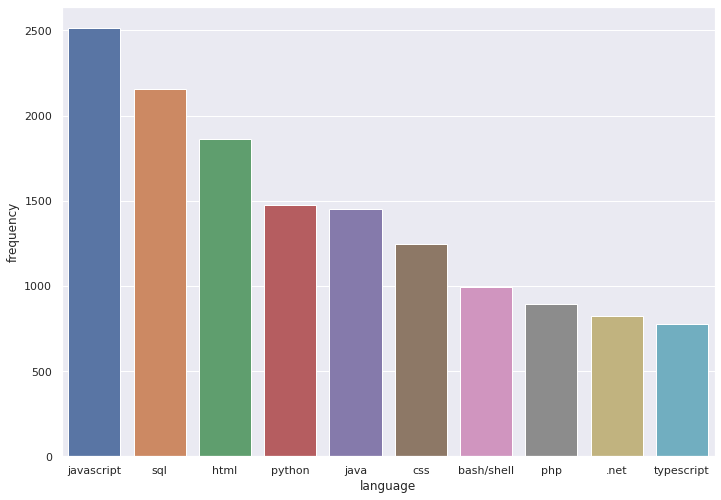

In [26]:
language_count=language_count[language_count['frequency']>735]
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
seaborn.barplot(data=language_count, x='language', y='frequency')
#ver cambiar el ancho
#elijo solo los primeros 5 para una correcta visualizacion

Elegimos los 10 lengujaes mas utilizados por las personas que realizaron la encuensta.

In [29]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
relevant_programming_lang = ['javascript', 'sql', 'html', 'java', 'python', 'css', 'bash/shell', 'php', '.net', 'typescript']
df_relevant_programming_lang =  df_main_inliers[df_main_inliers.programming_language.isin(relevant_programming_lang)]
df_relevant_programming_lang.describe()

,salary_monthly_NETO
count,12325.000000
mean,86100.531766
std,40288.118508
min,24500.000000
25%,56000.000000
50%,80000.000000
75%,105000.000000
max,248000.000000


<AxesSubplot:xlabel='programming_language', ylabel='salary_monthly_NETO'>

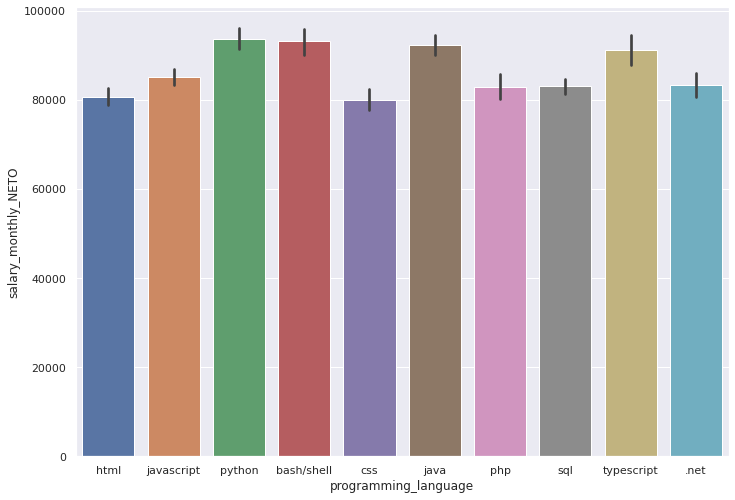

In [31]:
seaborn.barplot(data=df_relevant_programming_lang, x='programming_language', y='salary_monthly_NETO')

<AxesSubplot:xlabel='programming_language', ylabel='salary_monthly_NETO'>

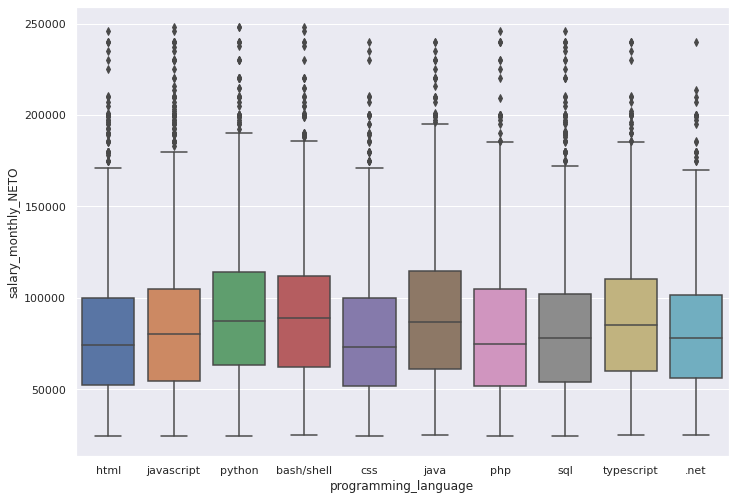

In [32]:
seaborn.boxplot(data=df_relevant_programming_lang, x='programming_language', y='salary_monthly_NETO')

Creamos nuevas columnas según el lenguaje para poder realizar un histograma con cada uno

In [45]:
relevant_programming_lang = ['javascript', 'sql', 'html', 'java', 'python', 'css', 'bash/shell', 'php', '.net', 'typescript']
for i in relevant_programming_lang:    
  if i == 'bash/shell' :
    df_relevant_programming_lang['bash_shell'] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
  elif i == '.net' :
    df_relevant_programming_lang['dot_net'] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
  else:
    df_relevant_programming_lang[i] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
df_relevant_programming_lang.head()

<ipython-input-45-298d0dbe02e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_programming_lang[i] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
<ipython-input-45-298d0dbe02e5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_programming_lang['bash_shell'] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
<ipython-input-45-298d0dbe02e5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages,javascript,sql,html,java,python,css,bash_shell,php,dot_net,typescript
1,html,"HTML, Javascript, Python",63000.0,"[html, javascript, python]",0,0,1,0,0,0,0,0,0,0
1,javascript,"HTML, Javascript, Python",63000.0,"[html, javascript, python]",1,0,0,0,0,0,0,0,0,0
1,python,"HTML, Javascript, Python",63000.0,"[html, javascript, python]",0,0,0,0,1,0,0,0,0,0
3,bash/shell,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p...",0,0,0,0,0,0,1,0,0,0
3,css,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p...",0,0,0,0,0,1,0,0,0,0


In [46]:
def histogram_hip(dataframe,var_a,var_b):
        ttestt = stats.ttest_ind(dataframe.query(f'{var_a} == 1')[var_b],dataframe.query(f'{var_a} == 0')[var_b])
        hist1 = dataframe.query(f'{var_a} == 1')[var_b].dropna()
        hist2 = dataframe.query(f'{var_a} == 0')[var_b].dropna() 
        mean1 = hist1.mean()
        mean2=hist2.mean()
        plt.subplot(1, 2, 1)
        plt.hist(hist1, alpha=.8, color='lightgrey')
        plt.axvline(mean1,color='red', label="Media: sueldo neto")
        plt.title(f"Hist. lenguaje:{var_a}".format(var_b, round(mean1, 3))),plt.legend()
        plt.subplot(1, 2, 2)
        plt.hist(hist2, alpha=.8, color='lightgrey')
        plt.axvline(mean2,color='red', label="Media: sueldo neto")
        plt.title("Hist. del resto de los lenguajes".format(var_b, round(mean2, 3))),plt.legend()
        plt.rcParams["figure.figsize"] = (15, 10)
        print (ttestt)
        print()
        print(f"Media del lenguaje: {var_a}",mean1 )
        print()
        print('Media del resto de los otros lenguajes:',mean2)
        print()
        print('Diferencia entre este lenguaje y los otros:',mean1-mean2)
        print()

Ttest_indResult(statistic=-1.2207842193636014, pvalue=0.22219108793897693)

Media del lenguaje: javascript 85136.78758604651

Media del resto de los otros lenguajes: 86304.17304275185

Diferencia entre este lenguaje y los otros: -1167.385456705335



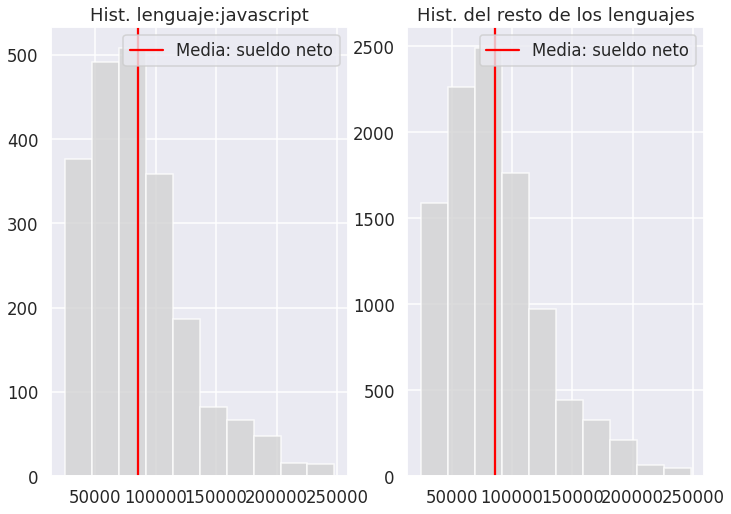

In [47]:
histogram_hip(df_relevant_programming_lang,'javascript','salary_monthly_NETO')

Ttest_indResult(statistic=7.202102805820429, pvalue=6.273818142633693e-13)

Media del lenguaje: python 93772.28702427565

Media del resto de los otros lenguajes: 85213.78018555394

Diferencia entre este lenguaje y los otros: 8558.506838721703



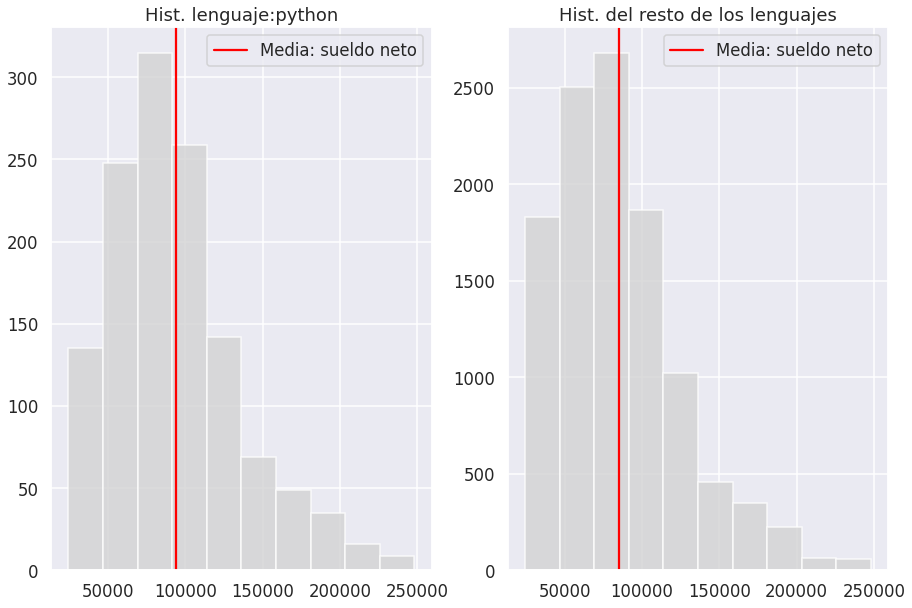

In [48]:
histogram_hip(df_relevant_programming_lang,'python','salary_monthly_NETO')

Ttest_indResult(statistic=-3.5663005711719977, pvalue=0.0003634283473010272)

Media del lenguaje: sql 83073.26129269575

Media del resto de los otros lenguajes: 86653.29473997313

Diferencia entre este lenguaje y los otros: -3580.033447277383



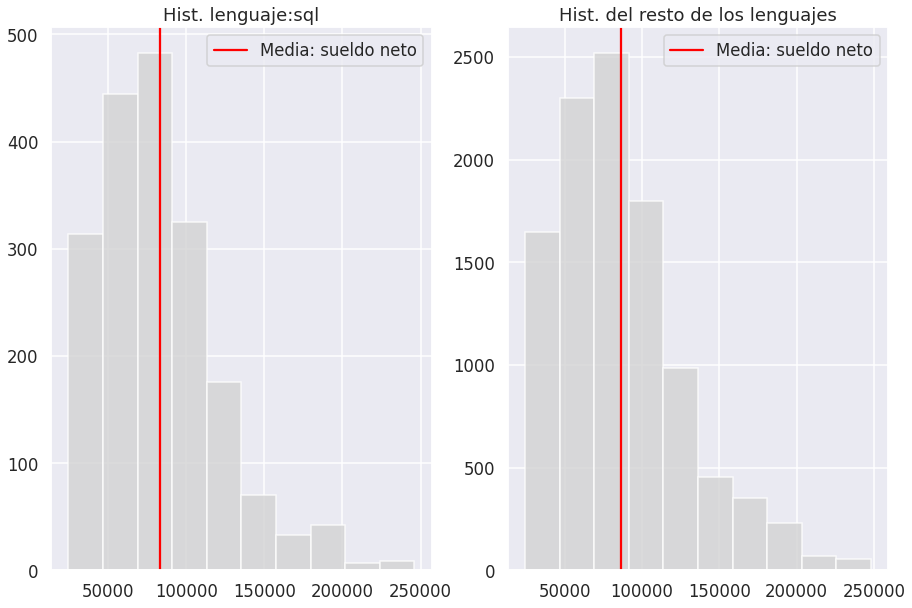

In [49]:
histogram_hip(df_relevant_programming_lang,'sql','salary_monthly_NETO')

Ttest_indResult(statistic=-5.819587483897606, pvalue=6.046124718782334e-09)

Media del lenguaje: html 80643.90475655432

Media del resto de los otros lenguajes: 86915.74359787372

Diferencia entre este lenguaje y los otros: -6271.838841319404



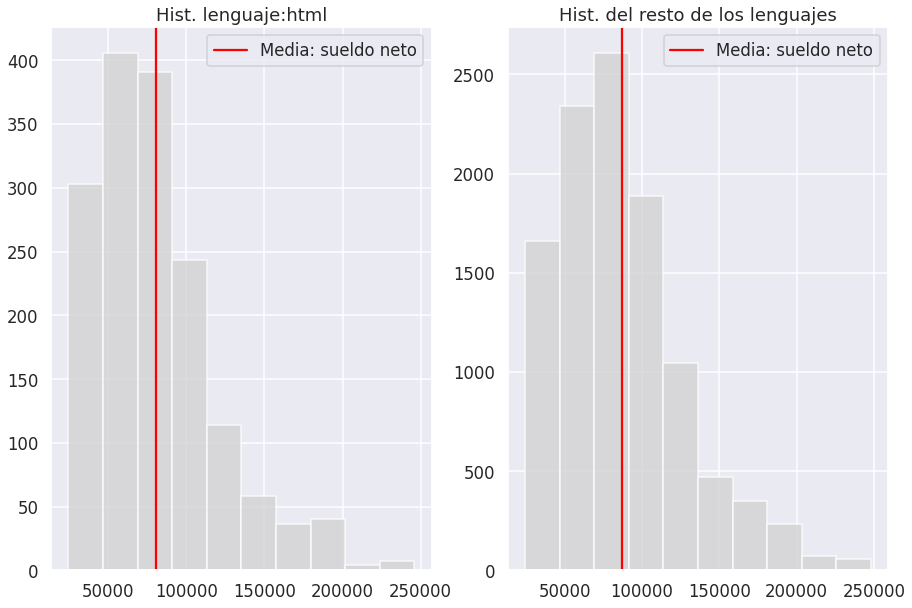

In [50]:
histogram_hip(df_relevant_programming_lang,'html','salary_monthly_NETO')

Ttest_indResult(statistic=5.915182268120818, pvalue=3.403055354317665e-09)

Media del lenguaje: java 92370.20494573643

Media del resto de los otros lenguajes: 85367.60214227458

Diferencia entre este lenguaje y los otros: 7002.60280346185



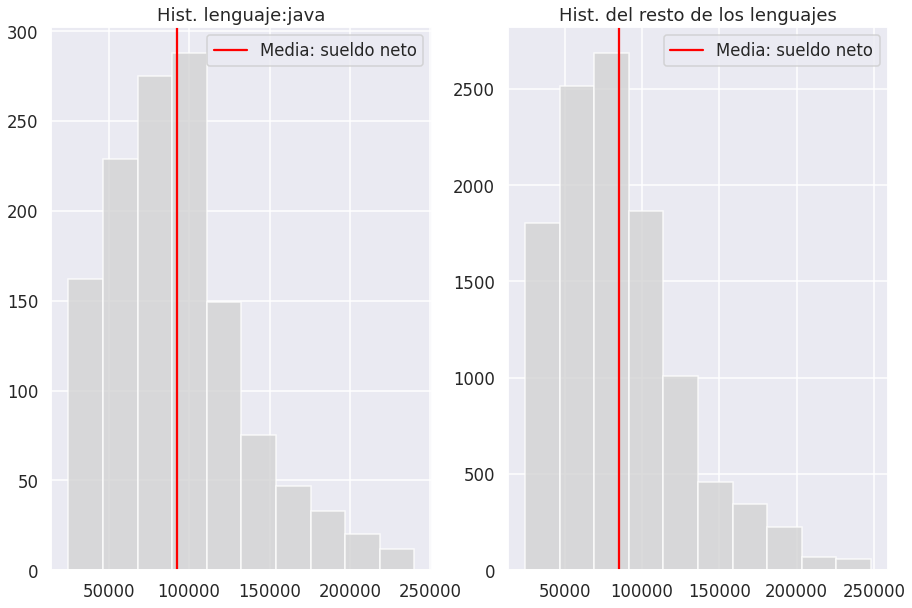

In [51]:
histogram_hip(df_relevant_programming_lang,'java','salary_monthly_NETO')

Ttest_indResult(statistic=-5.256105415194245, pvalue=1.4959557930994436e-07)

Media del lenguaje: css 79920.9398317757

Media del resto de los otros lenguajes: 86688.01851621503

Diferencia entre este lenguaje y los otros: -6767.07868443933



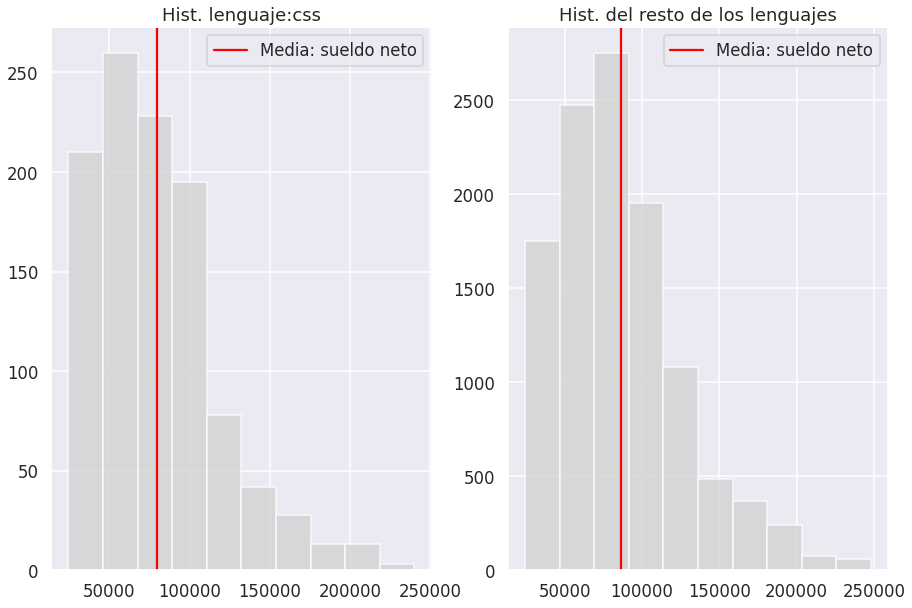

In [52]:
histogram_hip(df_relevant_programming_lang,'css','salary_monthly_NETO')

Ttest_indResult(statistic=5.426413635047215, pvalue=5.858528147545908e-08)

Media del lenguaje: bash_shell 93163.85395715898

Media del resto de los otros lenguajes: 85552.78156670748

Diferencia entre este lenguaje y los otros: 7611.072390451503



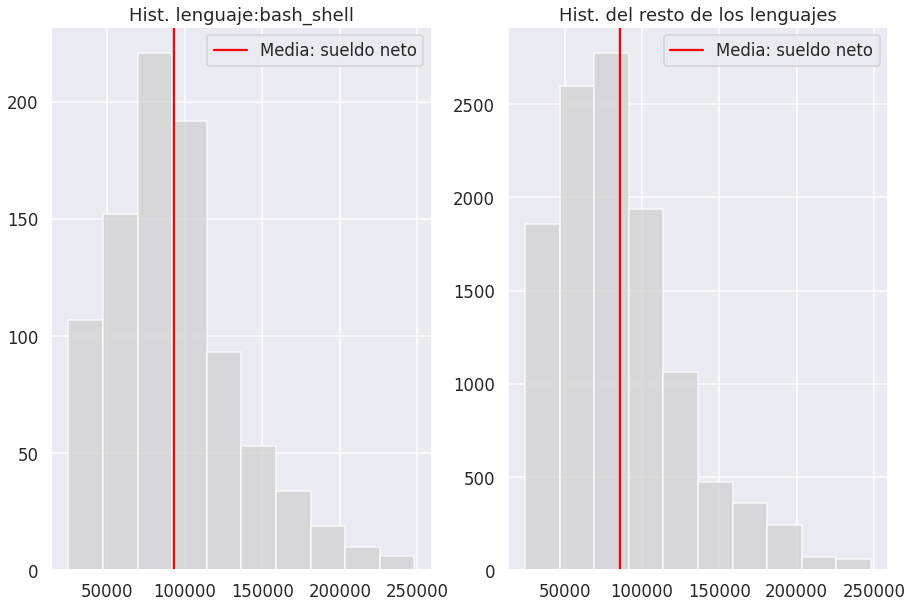

In [53]:
histogram_hip(df_relevant_programming_lang,'bash_shell','salary_monthly_NETO')

Ttest_indResult(statistic=-2.2018120255658795, pvalue=0.027697050579713743)

Media del lenguaje: php 83003.56483745124

Media del resto de los otros lenguajes: 86306.6210332295

Diferencia entre este lenguaje y los otros: -3303.056195778263



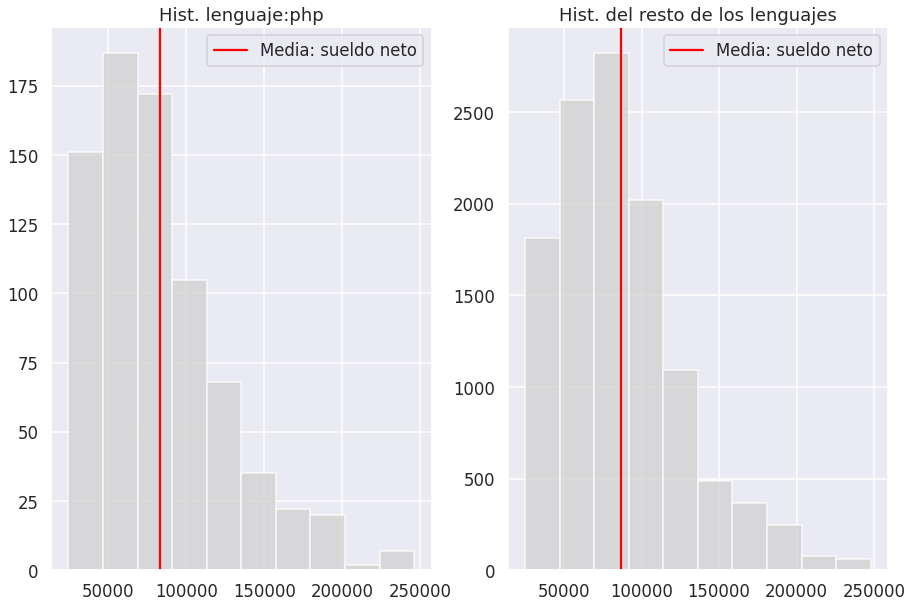

In [54]:
histogram_hip(df_relevant_programming_lang,'php','salary_monthly_NETO')

Ttest_indResult(statistic=-1.8408350456238496, pvalue=0.06566976109733408)

Media del lenguaje: dot_net 83412.8649232915

Media del resto de los otros lenguajes: 86266.5428902481

Diferencia entre este lenguaje y los otros: -2853.677966956602



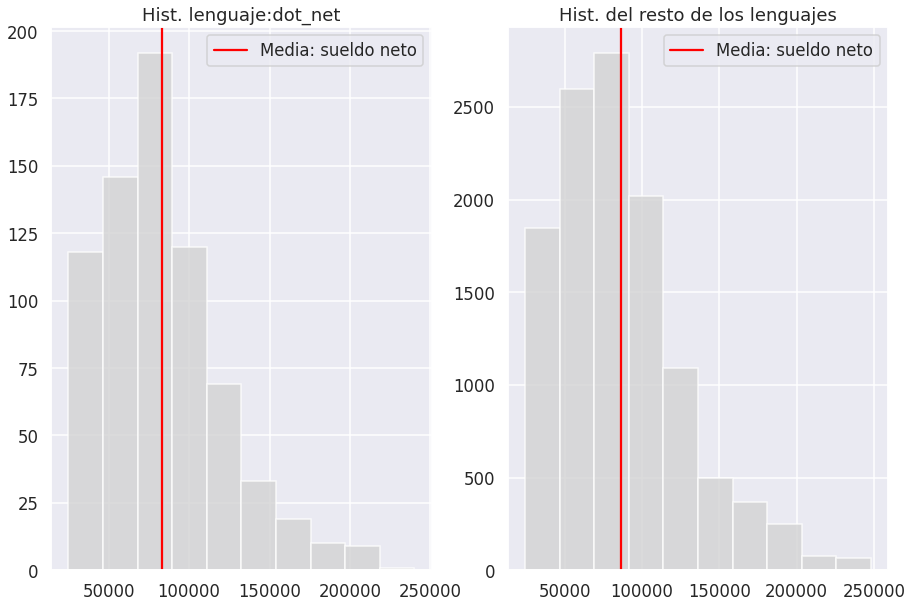

In [55]:
histogram_hip(df_relevant_programming_lang,'dot_net','salary_monthly_NETO')

Ttest_indResult(statistic=3.323714548573033, pvalue=0.0008908601192822308)

Media del lenguaje: typescript 91169.27962121212

Media del resto de los otros lenguajes: 85813.7444894985

Diferencia entre este lenguaje y los otros: 5355.535131713623



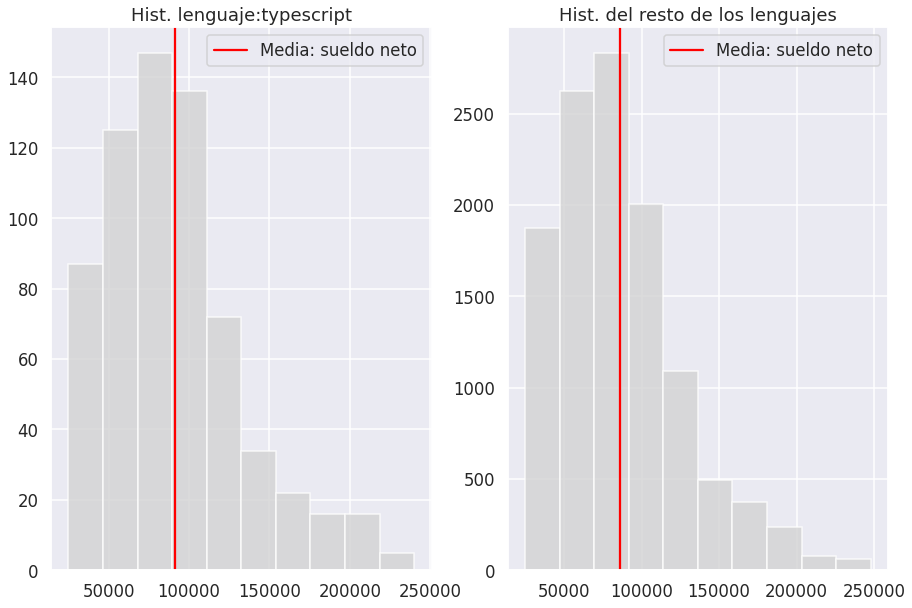

In [56]:
histogram_hip(df_relevant_programming_lang,'typescript','salary_monthly_NETO')

# Conclusión
Los que tienene diferencia negativa ganan por debajo de la media.
Los que tienen una diferencia positva ganan por arriba de la media.
A partir del df que armamos con el filtrado de outliers y lenguajes con mas frecuencia determinamos que los lenguajes asociados a los mejores salarios son: python, bash/shell, java y typescript

In [34]:
df_relevant_programming_lang.describe(include="object")

,programming_language,tools_programming_languages,cured_programming_languages
count,12325,12325,12325
unique,10,1366,1359
top,javascript,"CSS, HTML, Javascript","[css, html, javascript]"
freq,2150,300,300


In [ ]:
#for lang, group in filtered_df.groupby(“programming_language”):
    #print(lang, group.describe().round())

In [35]:
programming_col = 'programming_language'
salary_col = 'salary_monthly_NETO'
df_relevant_programming_lang[[programming_col, salary_col]].groupby(programming_col).describe()

salary_monthly_NETO                                       \
                                   count          mean           std      min   
programming_language                                                            
.net                               717.0  83412.864923  37086.781939  25000.0   
bash/shell                         887.0  93163.853957  41299.455606  25000.0   
css                               1070.0  79920.939832  37816.413838  24500.0   
html                              1602.0  80643.904757  38642.162305  24500.0   
java                              1290.0  92370.204946  41364.664884  25000.0   
javascript                        2150.0  85136.787586  41149.908737  24500.0   
php                                769.0  83003.564837  41759.544751  24500.0   
python                            1277.0  93772.287024  41792.420160  24500.0   
sql                               1903.0  83073.261293  37674.968202  24650.0   
typescript                         660.0  91169.279621  42105.679942  25000.0   

                                                            
                          25%      50%       75%       max  
programming_language                                        
.net                  56000.0  78000.0  101760.0  240000.0  
bash/shell            62110.0  89000.0  112000.0  248000.0  
css                   52000.0  73000.0  100000.0  240000.0  
html                  52290.0  74000.0  100000.0  246000.0  
java                  61000.0  87000.0  114750.0  240000.0  
javascript            54509.0  80000.0  105000.0  248000.0  
php                   51500.0  75000.0  105000.0  246000.0  
python                63000.0  87500.0  114000.0  248000.0  
sql                   54000.0  78000.0  102000.0  246000.0  
typescript            60000.0  85000.0  110250.0  240000.0

In [12]:
relevant_programming_lang = ['javascript', 'sql', 'html', 'java', 'python', 'css', 'bash/shell', 'php', '.net', 'typescript']
df_filtered = df_lang[df_lang.programming_language.isin(relevant_programming_lang)]
df_filtered.describe()

,salary_monthly_NETO
count,1.367000e+04
mean,9.859455e+04
std,1.021389e+05
min,1.000000e+00
25%,5.342500e+04
50%,8.000000e+04
75%,1.100000e+05
max,2.080000e+06


In [ ]:

for i in relevant_programming_lang:
  if i == 'bash/shell':
    df_lang['bash_shell'] = np.where(df_relevant_programming_lang['programming_language']== i,1,0)
  elif i == '.net' :
    df_lang['dot_net'] = np.where(df_relevant_programming_lang['programming_language']== i,1,0)
  elif i == 'c#' :
    df_lang['c_sharp'] = np.where(df_relevant_programming_lang['programming_language']== i,1,0)
  elif i == 'c++' :
    df_lang['c_plus'] = np.where(df_relevant_programming_lang['programming_language']== i,1,0)
  else:
    df_relevant_programming_lang[i] = np.where(df_relevant_programming_lang['programming_language']== i,1,0)
df_relevant_programming_lang.head()